# Model Building: Neural Network

In [1]:
# Install packages needed to build the neural network

In [3]:
install.packages("rsample", repos = "https://cloud.r-project.org", dependencies=TRUE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘lazyeval’, ‘prodlim’, ‘future’, ‘globals’, ‘warp’, ‘rex’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘furrr’, ‘slider’, ‘covr’, ‘modeldata’, ‘recipes’




In [2]:
install.packages(c("tensorflow","keras","reticulate"), repos="https://cloud.r-project.org")


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘config’, ‘tfruns’, ‘tfautograph’, ‘zeallot’, ‘RcppTOML’, ‘here’, ‘png’




In [4]:
install.packages("caret", repos="https://cloud.r-project.org", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.methodsS3’, ‘R.oo’, ‘R.utils’, ‘bitops’, ‘rbibutils’, ‘R.cache’, ‘caTools’, ‘TH.data’, ‘profileModel’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘Rdpack’, ‘RcppEigen’, ‘plotrix’, ‘styler’, ‘classInt’, ‘labelled’, ‘gplots’, ‘libcoin’, ‘matrixStats’, ‘multcomp’, ‘iterators’, ‘brglm’, ‘gtools’, ‘lme4’, ‘qvcalc’, ‘Formula’, ‘plotmo’, ‘combinat’, ‘questionr’, ‘ROCR’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’, ‘ROSE’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘reshape2’, ‘BradleyTerry2’, ‘Cubist’, ‘earth’, ‘ellipse’, ‘fastICA’, ‘gam’, ‘kernlab’, ‘klaR’, ‘mda’, ‘mlbench’, ‘MLmetrics’, ‘pamr’, ‘party’, ‘pls’, ‘proxy’, ‘randomForest’, ‘RANN’, ‘spls’, ‘superpc’, ‘themis’




In [5]:
install.packages("keras3", repos="https://cloud.r-project.org", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dotty’, ‘tfdatasets’, ‘jpeg’




In [6]:
install.packages("smotefamily", repos="https://cloud.r-project.org", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘FNN’, ‘dbscan’, ‘igraph’




In [7]:
# Load libraries
library(readr)
library(dplyr)
library(rsample)
library(caret)

library(reticulate) # connect R with python

py_require("tensorflow")

library(tensorflow)
library(keras3)

py_config()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:rsample’:

    calibration



Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train



Attaching package: ‘keras3’


The following objects are masked from ‘package:tensorflow’:

    set_random_seed, shape




python:         /root/.cache/uv/archive-v0/HFNRAfVgH1vw50ggBK3KL/bin/python
libpython:      /usr/lib/python3.12/config-3.12-x86_64-linux-gnu/libpython3.12.so
pythonhome:     /root/.cache/uv/archive-v0/HFNRAfVgH1vw50ggBK3KL:/root/.cache/uv/archive-v0/HFNRAfVgH1vw50ggBK3KL
virtualenv:     /root/.cache/uv/archive-v0/HFNRAfVgH1vw50ggBK3KL/bin/activate_this.py
version:        3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy:          /root/.cache/uv/archive-v0/HFNRAfVgH1vw50ggBK3KL/lib/python3.12/site-packages/numpy
numpy_version:  2.0.2
keras:          /root/.cache/uv/archive-v0/HFNRAfVgH1vw50ggBK3KL/lib/python3.12/site-packages/keras

NOTE: Python version was forced by py_require()

In [8]:
# Read data
df <- read_csv("polish_preprocessed.csv") %>%
  mutate(class = ifelse(class == 1, 1, 0)) %>%     # force 0/1
  mutate(across(everything(), ~ifelse(is.infinite(.), NA, .))) %>%
  na.omit()

Rows: 7027 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (63): ROA_net_profit_total_assets, Total_liabilities_total_assets, Worki...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
# 80/20 split (stratified - keep balance 0/1 similar between train and test)
set.seed(42)
split <- initial_split(df, prop = 0.80, strata = class)
train_df <- training(split)
test_df  <- testing(split)

x_train <- as.matrix(select(train_df, -class))
y_train <- as.numeric(train_df$class)

x_test  <- as.matrix(select(test_df, -class))
y_test  <- as.numeric(test_df$class)

In [10]:
# Load library to balance data
library(ROSE)

# Balance data
balanced_data <- ovun.sample(class ~ .,              # Use 'class' no 'y'
                             data = train_df,        # Use train_df directly
                             method = "both",        # Delete majority class & create minority class
                             p = 0.5,                # 50% each class - balanced
                             seed = 123)$data

# Separate correctly
x_train_balanced <- as.matrix(balanced_data[, -ncol(balanced_data)])
y_train_balanced <- as.numeric(as.character(balanced_data$class))  # Use 'class'

# Safer, using name of last column:
y_train_balanced <- as.numeric(as.character(balanced_data[, ncol(balanced_data)]))

Loaded ROSE 0.0-4




In [11]:
# Majority baseline (on train - not balanced)
1-mean(y_train)

[1] 0.9619285

In [12]:
# Building initial neural network to understand our data
model <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = "tanh",             # 1 hidden layer (32 neurons & activation tanh -1 to 1)
              input_shape = ncol(x_train_balanced)) %>%
  layer_dense(units = 1, activation = "sigmoid")           # 1 output layer (1 neuron & activation sigmoid 0 to 1: prob. bankrupt)

model %>% compile(                                         # control learning of network
  optimizer = optimizer_adam(learning_rate = 0.001),
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  x_train_balanced, y_train_balanced,  # train model on balanced data
  epochs = 100,                        # how many times pass through entire dataset
  batch_size = 32,                     # mini groups of 32
  validation_split = 0.2,              # 20% of train to validate results
  verbose = 1,
)

In [13]:
# Predictions with threshold 0.5
prob_test <- as.numeric(predict(model, x_test))
pred_test <- ifelse(prob_test > 0.5, 1, 0)      # if prob > 0.5 then class is 1

# Create confusion matrix
cm <- caret::confusionMatrix(
  factor(pred_test, levels = c(0,1)),
  factor(y_test, levels = c(0,1)),
  positive = "1"                       # important predict class 1 (bankrupt)
)

# Get metrics
acc <- as.numeric(cm$overall["Accuracy"])       # total correct predictions
sens <- as.numeric(cm$byClass["Sensitivity"])   # bankrup correct predictions - IMPORTANT
spec <- as.numeric(cm$byClass["Specificity"])   # non-bankrupt correct predictions

cat("\n--- TEST METRICS (thr=0.5) ---\n")
cat("Accuracy:", round(acc, 4), "\n")
cat("Sensitivity (Recall, class=1):", round(sens, 4), "\n")
cat("Specificity (class=0):", round(spec, 4), "\n\n")
print(cm$table)


--- TEST METRICS (thr=0.5) ---
Accuracy: 0.8883 
Sensitivity (Recall, class=1): 0.3509 
Specificity (class=0): 0.911 

          Reference
Prediction    0    1
         0 1229   37
         1  120   20


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases




AUC: 0.7835 

Best threshold according to Youden:
  threshold sensitivity specificity
1 0.1783059   0.8245614   0.6686434


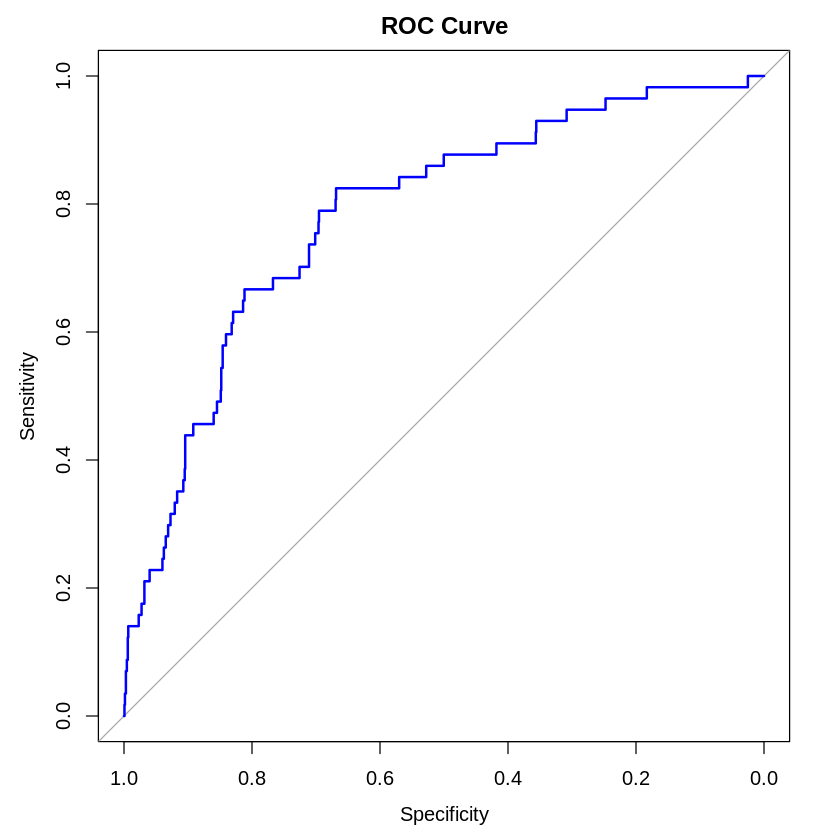

In [14]:
# Load library for ROC/AUC
library(pROC)

# Plot ROC curve (trade-off sensitivity & specificity)
roc_obj <- roc(y_test, prob_test)
plot(roc_obj, main = "ROC Curve", col = "blue", lwd = 2)
cat("\nAUC:", round(auc(roc_obj), 4), "\n")

# Find optimal threshold
best_coords <- coords(roc_obj, "best", ret = c("threshold", "sensitivity", "specificity"))
cat("\nBest threshold according to Youden:\n")
print(best_coords)

In [15]:
# Hyperparameter tuning to find optimal combination for our model

# Define options
units_options <- seq(10, 50, by = 10)  # 10, 20, 30, 40, 50
activation_options <- c("softplus", "sigmoid", "tanh")
batch_options <- c(8, 16, 32, 64)

# Create grid
param_grid <- expand.grid(
  units = units_options,
  activation = activation_options,
  batch_size = batch_options
)

cat("Total combinatons:", nrow(param_grid), "\n\n")

# Store results
results <- data.frame()


Total combinatons: 60 



In [ ]:
# Grid search - try each combination
for (i in 1:nrow(param_grid)) {

  cat("Trying", i, "/", nrow(param_grid), "- units:", param_grid$units[i],
      "activation:", param_grid$activation[i],
      "batch:", param_grid$batch_size[i], "\n")

  # Create model
  model <- keras_model_sequential() %>%
    layer_dense(units = param_grid$units[i],
                activation = as.character(param_grid$activation[i]),
                input_shape = ncol(x_train_balanced)) %>%
    layer_dense(units = 1, activation = "sigmoid")

  # Compile
  model %>% compile(
    optimizer = optimizer_adam(learning_rate = 0.001),
    loss = "binary_crossentropy",
    metrics = c("accuracy")
  )

  # Train
  history <- model %>% fit(
    x_train_balanced, y_train_balanced,
    epochs = 100,
    batch_size = param_grid$batch_size[i],
    validation_split = 0.2,
    verbose = 0

  )

  # Obtain data of validation (same seed for consistency)
  set.seed(123)
  n <- nrow(x_train_balanced)
  val_idx <- sample(1:n, size = floor(0.2 * n))
  x_val <- x_train_balanced[val_idx, ]
  y_val <- y_train_balanced[val_idx]

  # Predict
  prob_val <- as.numeric(predict(model, x_val, verbose = 0))

  # Calculate AUC
  auc_val <- auc(roc(y_val, prob_val, quiet = TRUE))

  # Save result
  results <- rbind(results, data.frame(
    units = param_grid$units[i],
    activation = as.character(param_grid$activation[i]),
    batch_size = param_grid$batch_size[i],
    auc = as.numeric(auc_val)
  ))

  cat("  AUC:", round(auc_val, 4), "\n\n")
}

Trying 1 / 60 - units: 10 activation: 1 batch: 8 
  AUC: 0.8609 

Trying 2 / 60 - units: 20 activation: 1 batch: 8 
  AUC: 0.8878 

Trying 3 / 60 - units: 30 activation: 1 batch: 8 
  AUC: 0.8994 

Trying 4 / 60 - units: 40 activation: 1 batch: 8 
  AUC: 0.9034 

Trying 5 / 60 - units: 50 activation: 1 batch: 8 
  AUC: 0.9185 

Trying 6 / 60 - units: 10 activation: 2 batch: 8 
  AUC: 0.87 

Trying 7 / 60 - units: 20 activation: 2 batch: 8 
  AUC: 0.8871 

Trying 8 / 60 - units: 30 activation: 2 batch: 8 
  AUC: 0.8959 

Trying 9 / 60 - units: 40 activation: 2 batch: 8 
  AUC: 0.8999 

Trying 10 / 60 - units: 50 activation: 2 batch: 8 
  AUC: 0.9131 

Trying 11 / 60 - units: 10 activation: 3 batch: 8 
  AUC: 0.9229 

Trying 12 / 60 - units: 20 activation: 3 batch: 8 
  AUC: 0.9508 

Trying 13 / 60 - units: 30 activation: 3 batch: 8 
  AUC: 0.9634 

Trying 14 / 60 - units: 40 activation: 3 batch: 8 
  AUC: 0.9634 

Trying 15 / 60 - units: 50 activation: 3 batch: 8 
  AUC: 0.9751 

Trying

In [ ]:
# Order results by AUC
results <- results[order(-results$auc), ]
print(head(results, 5), row.names = FALSE)

 units activation batch_size       auc
    50       tanh          8 0.9751124
    40       tanh          8 0.9634051
    30       tanh          8 0.9633640
    20       tanh          8 0.9507824
    50       tanh         16 0.9466329


In [ ]:
# Best model
best <- results[1, ]

cat("Units:      ", best$units, "\n")
cat("Activation: ", best$activation, "\n")
cat("Batch size: ", best$batch_size, "\n")
cat("AUC:        ", round(best$auc, 4), "\n")

Units:       50 
Activation:  tanh 
Batch size:  8 
AUC:         0.9751 


In [ ]:
# Train final model with optimal hyperparameters
model <- keras_model_sequential() %>%
  layer_dense(units = best$units,
              activation = as.character(best$activation),
              input_shape = ncol(x_train_balanced)) %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = optimizer_adam(learning_rate = 0.001),
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

history <- model %>% fit(
  x_train_balanced, y_train_balanced,
  epochs = 100,
  batch_size = best$batch_size,
  validation_split = 0.2,
  verbose = 1

)

cat("\n✓ Final model trained with best hyperparameters\n")


✓ Final model trained with best hyperparameters


In [ ]:
# Final model evaluation on test

# Predict probabilities on test set
prob_test_final <- as.numeric(predict(model, x_test))

In [ ]:
# Threshold = 0.5 (to compare)

# Convert probabilities to classes
pred_test_final <- ifelse(prob_test_final > 0.5, 1, 0)

# Confusion matrix
cm_final <- caret::confusionMatrix(
  factor(pred_test_final, levels = c(0,1)),
  factor(y_test, levels = c(0,1)),
  positive = "1"
)

# Extract metrics
acc_final  <- as.numeric(cm_final$overall["Accuracy"])
sens_final <- as.numeric(cm_final$byClass["Sensitivity"])
spec_final <- as.numeric(cm_final$byClass["Specificity"])

[1] "AUC = 0.7578"


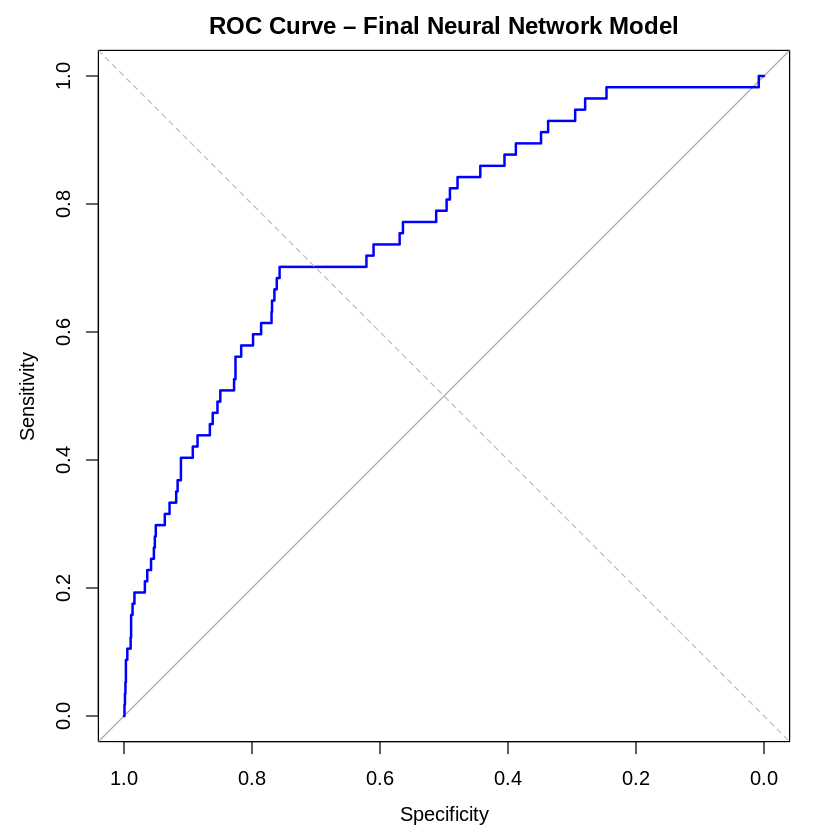

In [ ]:
# ROC and AUC to see performance and find optimal threshold
roc_final <- roc(response = y_test,
                 predictor = prob_test_final,
                 levels = c(0, 1),
                 direction = "<")

auc_final <- as.numeric(auc(roc_final))
print(paste("AUC =", round(auc_final, 4)))

# Plot ROC curve
plot(roc_final, main = "ROC Curve – Final Neural Network Model", col = "blue", lwd = 2)
abline(a = 0, b = 1, lty = 2, col = "gray")


In [ ]:
# Find optimal threshold
best_coords <- coords(
  roc_final,
  "best",
  ret = c("threshold", "sensitivity", "specificity")
)

opt_thr <- as.numeric(best_coords["threshold"])

cat("\nBest threshold according to Youden:\n")
print(best_coords)


Best threshold according to Youden:
  threshold sensitivity specificity
1 0.2418064   0.7017544   0.7568569


In [ ]:
# Threshold = optimal (Youden)

# Convert probabilities to classes
pred_test_opt <- ifelse(prob_test_final > opt_thr, 1, 0)

#Confusion matrix
cm_opt <- caret::confusionMatrix(
  factor(pred_test_opt, levels = c(0,1)),
  factor(y_test, levels = c(0,1)),
  positive = "1"
)

# Extract metrics
acc_opt  <- as.numeric(cm_opt$overall["Accuracy"])
sens_opt <- as.numeric(cm_opt$byClass["Sensitivity"])
spec_opt <- as.numeric(cm_opt$byClass["Specificity"])

In [ ]:
# Print results
cat("\n================ FINAL MODEL PERFORMANCE ================\n")

cat("\n--- Threshold = 0.5 (Standard) ---\n")
cat("Accuracy:    ", round(acc_final, 4), "\n")
cat("Sensitivity: ", round(sens_final, 4), "\n")
cat("Specificity: ", round(spec_final, 4), "\n")
cat("AUC:         ", round(auc_final, 4), "\n\n")
print(cm_final$table)

cat("\n--- Threshold = Optimal (Youden) ---\n")
cat("Optimal threshold:", round(opt_thr, 4), "\n")
cat("Accuracy:    ", round(acc_opt, 4), "\n")
cat("Sensitivity: ", round(sens_opt, 4), "\n")
cat("Specificity: ", round(spec_opt, 4), "\n")
cat("AUC:         ", round(auc_final, 4), "\n\n")
print(cm_opt$table)


================ FINAL MODEL PERFORMANCE ================

--- Threshold = 0.5 (Standard) ---
Accuracy:     0.8684 
Sensitivity:  0.4211 
Specificity:  0.8873 
AUC:          0.7578 

          Reference
Prediction    0    1
         0 1197   33
         1  152   24

--- Threshold = Optimal (Youden) ---
Optimal threshold: 0.2418 
Accuracy:     0.7546 
Sensitivity:  0.7018 
Specificity:  0.7569 
AUC:          0.7578 

          Reference
Prediction    0    1
         0 1021   17
         1  328   40
